# TriageAssist: auditing the dataset

In [1]:
import pandas as pd

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category = FutureWarning)
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category = FutureWarning)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import (
    count,
    selection_rate,
    equalized_odds_difference,
    false_positive_rate,
    false_negative_rate,
)
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import ExponentiatedGradient
from fairlearn.reductions import EqualizedOdds
from sklearn.model_selection import train_test_split
import warnings

warnings.simplefilter("ignore")

rand_seed = 1234
np.random.seed(rand_seed)

In [3]:
# load data
df = pd.read_csv('heart.csv', header = 0)
df.columns = ['Age','Sex','ChestPainType','RestingBP','Cholesterol','FastingBS','RestingECG','MaxHR','ExerciseAngina','Oldpeak','ST_Slope','HeartDisease']

### 1 = male, 0 = female
print(df.isnull().sum())

df['Sex'] = df.Sex.map({'F': 'female', 'M': 'male'})

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


In [4]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,male,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,female,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,male,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,female,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,male,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


<Axes: >

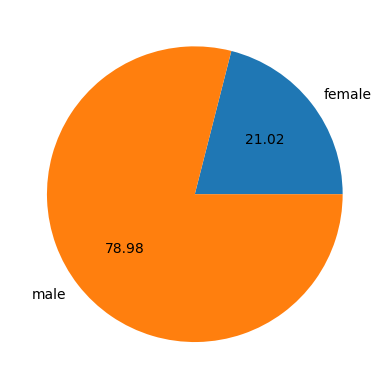

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

df.groupby('Sex').size().plot(kind = 'pie',autopct = '%.2f')

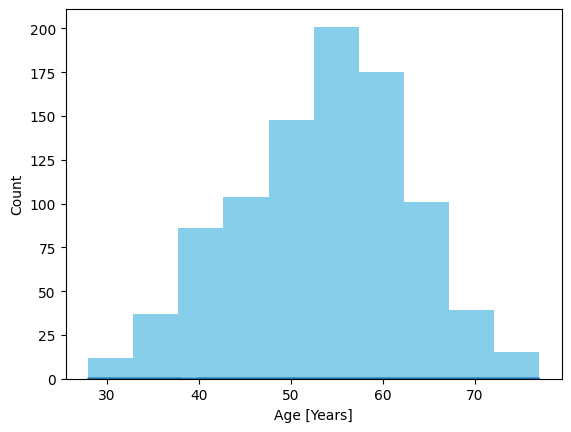

In [22]:


plt.hist(df['Age'], color = "skyblue")



plt.show()

<Axes: xlabel='Age [Years]', ylabel='Count'>

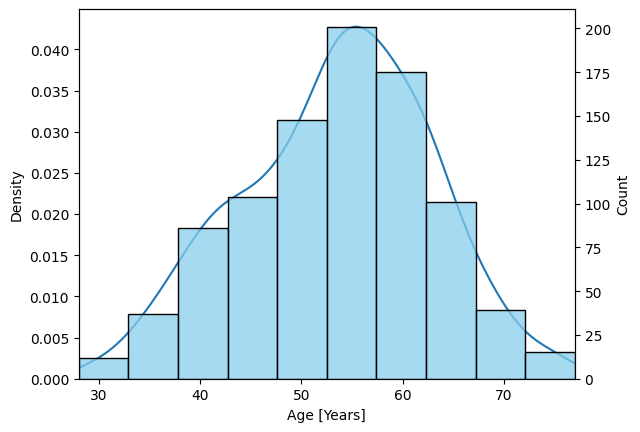

In [32]:
fig, ax1 = plt.subplots()
sns.kdeplot(data=df, x="Age", ax=ax1)
ax1.set_xlim((df["Age"].min(), df["Age"].max()))
ax2 = ax1.twinx()

plt.xlabel('Age [Years]')
plt.ylabel('Count')
ax1.set(xlabel='Age [Years]')
sns.histplot(data=df, x="Age", ax=ax2, bins=10, color = 'skyblue')

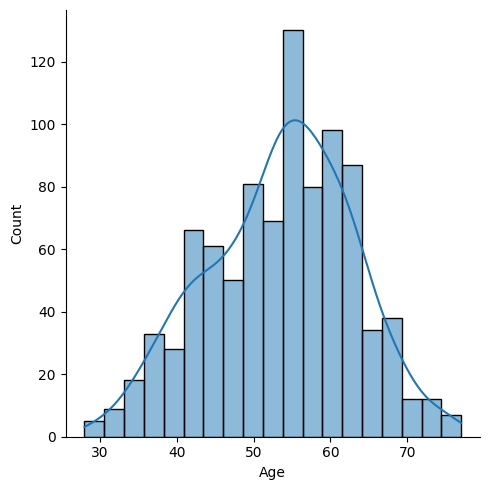

In [18]:

sns.displot(df['Age'], kde =True)

<Axes: >

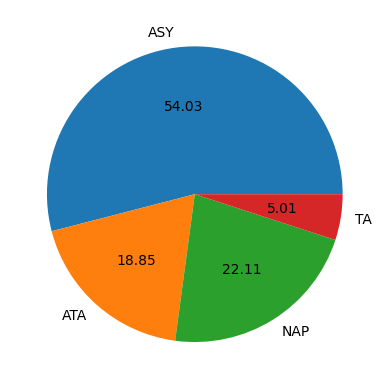

In [12]:
df.groupby('ChestPainType').size().plot(kind = 'pie',autopct = '%.2f')

<Axes: xlabel='HeartDisease', ylabel='Age'>

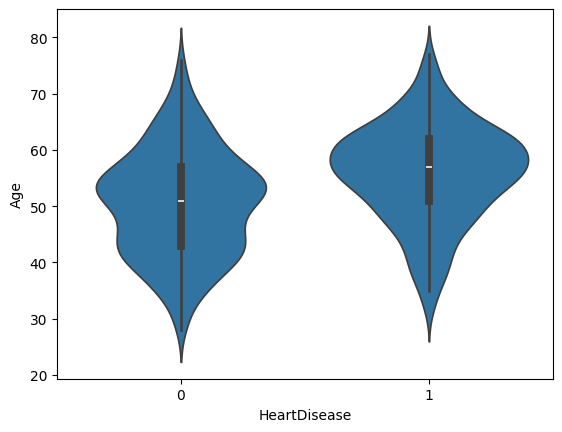

In [14]:
sns.violinplot(y = df['Age'], x = df['HeartDisease'])

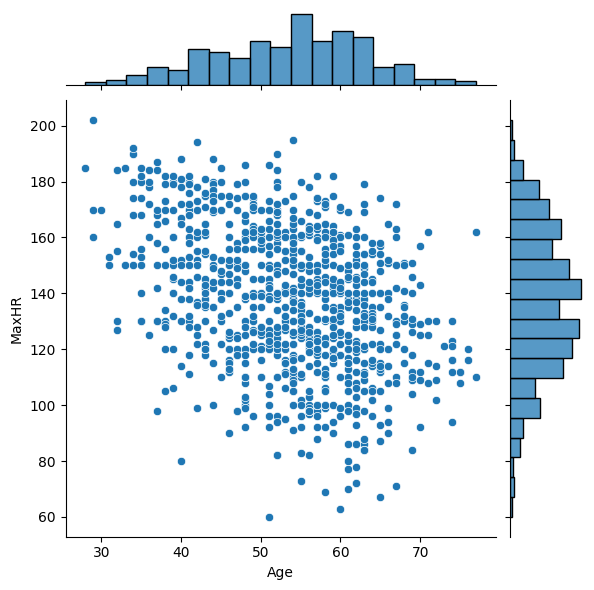

In [15]:
sns.jointplot(x = 'Age', y = 'MaxHR', data = df)

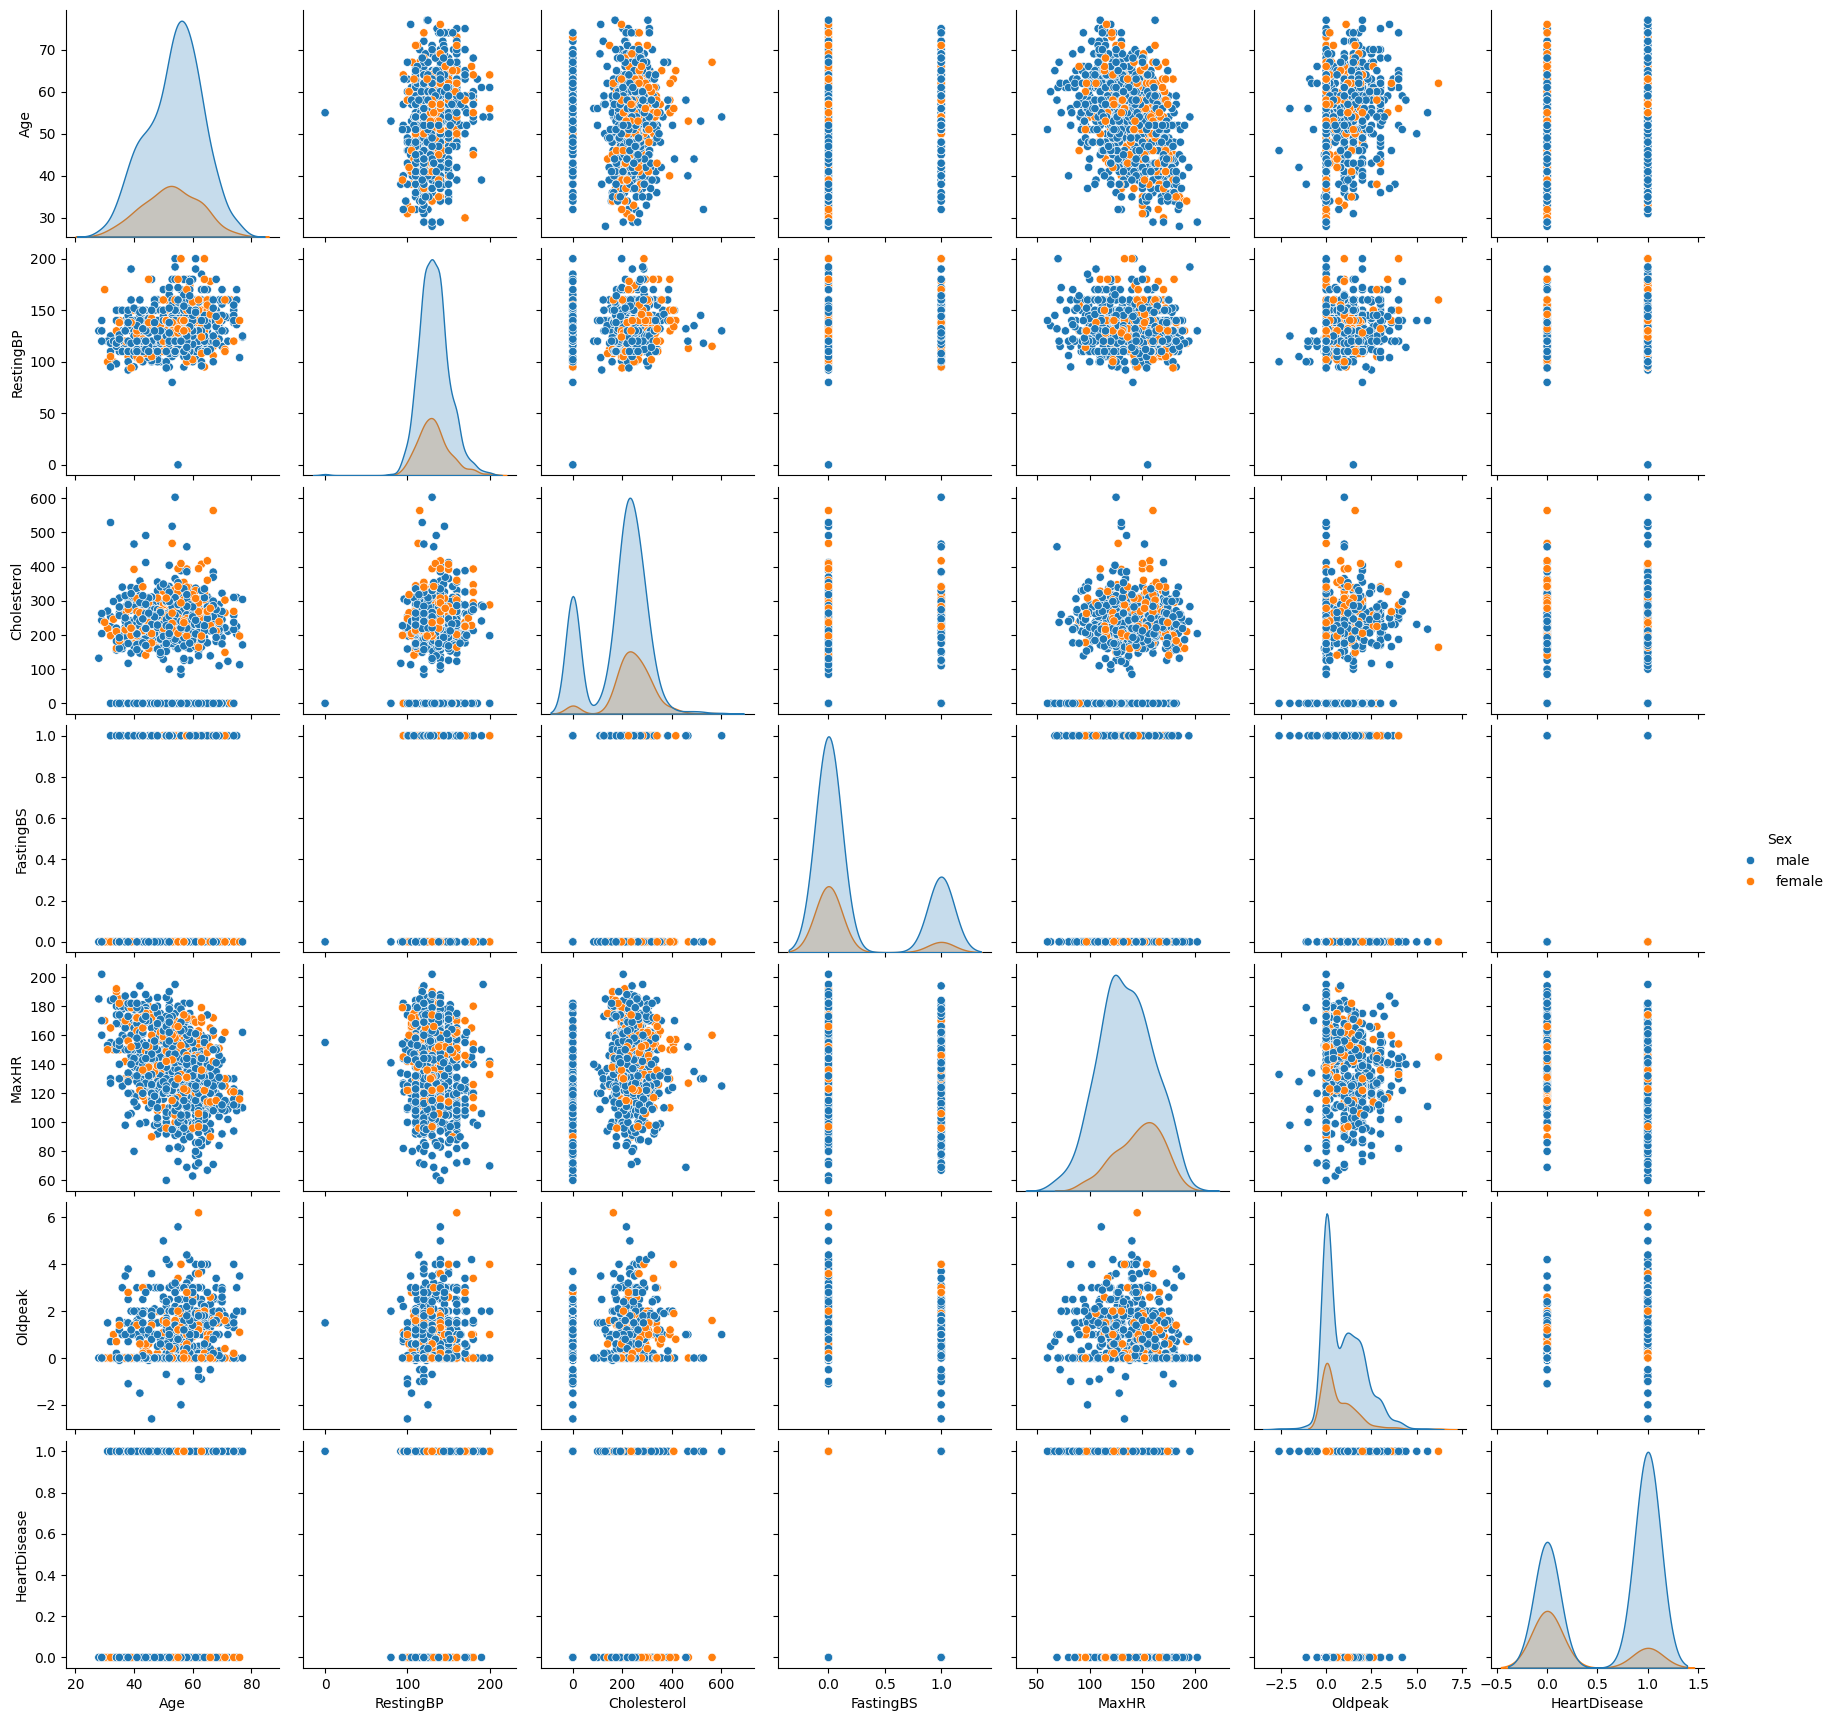

In [17]:
sns.pairplot(data=df,hue='Sex')
plt.show()

In [7]:
categorical_features = ["Sex"]

for col_name in categorical_features:
    df[col_name] = df[col_name].astype("category")

Y, A = df.loc[:, "HeartDisease"], df.loc[:, "Sex"]
X = pd.get_dummies(df.drop(columns=["HeartDisease", "Sex"]))

In [10]:
# gender
A.value_counts(normalize=True)

Sex
male      0.78976
female    0.21024
Name: proportion, dtype: float64

In [9]:
# target
Y.value_counts(normalize=True)

HeartDisease
1    0.553377
0    0.446623
Name: proportion, dtype: float64